# MCO1: Technical Report

DATAPRE S14

- Aldecoa, Renzel Raphael
- Bautista, Carlo Gabriel
- Canicon, Jan Ambro
- Lim, Christopher

# Important notes
- Some of the cells are changed from code cells to "raw" cell ([source](https://stackoverflow.com/questions/34192290/ipython-notebook-elegant-way-of-turning-off-part-of-cells)) in order to stop them from running. These were "frozen" from running as they would be performing web scraping and data cleaning—causing long run times and errors for the preprocessing cells (since they would be reading from already-preprocessed data).
- If running every code cell from the start, please convert the corresponding cell to a code cell before running all cells. These are marked with "RUN ONCE" as a header comment.
- An alternative is to run only the **Library Imports** and then "Run All Below" from **Exploratory Data Analysis**.

# CS:GO Players Ranked Statistics
*Counter-Strike: Global Offensive* is a first-person tactical shooter with a ranked competitive game mode. Players would matchmake for a 5-versus-5 lobby with players of the same or similar skill level in order to try improving their ranks. The ranks are divided into:
- The lower tier; Silver 1 through 4, Silver Elite, & Silver Elite Master
- The middle tier; Gold Nova 1 through 4
- The upper tier; Master Guardian 1 & 2, Master Guardian Elite, & Distinguished Master Guardian
- The top tier; Legendary Eagle, Legendary Egle Master, Supreme Master First Class, & The Global Elite


One of the major "concerns" by the playerbase is that **if player statistics matter when determining their rank**. This notebook serves to answer the following questions:
1. What are the average stats (K/D, 1vX, Rating, etc.) of players in each rank?
2. Do higher ranking players tend to perform better than lower ranked ones?
3. How much do player stats predict rankings?

## Library Imports

In [2]:
import requests
import json
import pandas as pd
import numpy as np
import time
import random
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from scipy import stats
from sklearn import preprocessing

# Data Scraping

## Set constant variables

In [2]:
base_url = 'https://csgostats.gg/'
leaderboards_url = 'https://csgostats.gg/leaderboards'

## Get list of ranks and the urls for each rank leaderboard.

### Using Requests (can't scrape due to captcha)

In [3]:
# RUN ONCE
result = requests.get(leaderboards_url)
soup = BeautifulSoup(result.text, 'html.parser')
soup

<!DOCTYPE html>

<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>
<title>Attention Required! | Cloudflare</title>
<meta charset="utf-8"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="IE=Edge" http-equiv="X-UA-Compatible"/>
<meta content="noindex, nofollow" name="robots"/>
<meta content="width=device-width,initial-scale=1" name="viewport"/>
<link href="/cdn-cgi/styles/cf.errors.css" id="cf_styles-css" rel="stylesheet"/>
<!--[if lt IE 9]><link rel="stylesheet" id='cf_styles-ie-css' href="/cdn-cgi/styles/cf.errors.ie.css" /><![endif]-->
<style>body{margin:0;padding:0}</style>
<!--[if gte IE 10]><!-->
<script>
  if (!navigator.cookieEnabled) {
    window.addEventListener('DOMContentLoaded', function

### Using selenium (success)

In [8]:
# RUN ONCE
username = 'chris'

# webdriver options
chromeOptions = Options()
# chromeOptions.add_argument('--kiosk')                          # sets the headless browser into full screen mode
# chromeOptions.add_argument('--headless')                       # opens the browser silently (hides it, if you enable this, make sure to disable kiosk)
chromeOptions.add_argument('--log-level=3')                    # stops the headless browser's logging features
# chromeOptions.add_argument('blink-settings=imagesEnabled=false') # set loading images to be false (for faster loading)
chromeOptions.add_argument('--no-sandbox')                     # required when running as root user. otherwise you would get no sandbox errors. 
chromeOptions.add_argument('--disable-extensions')
chromeOptions.add_argument('--disable-gpu')
chromeOptions.page_load_strategy = 'eager'

# to prevent getting a captcha, make it look like that the bot is a human
chromeOptions.add_argument("--profile-directory=Default")
chromeOptions.add_argument("--user-data-dir=C:/Users/%s/AppData/Local/Google/Chrome/User Data" % username)
chromeOptions.add_argument('--disable-blink-features=AutomationControlled')

chromeOptions.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36")

# Run the Driver
driver = webdriver.Chrome('./chromedriver/chromedriver.exe', options=chromeOptions, service_args=['--verbose'])

C:\Users\chris\AppData\Local\Temp\ipykernel_2248\2506721761.py:22: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('./chromedriver/chromedriver.exe', options=chromeOptions, service_args=['--verbose'])


In [ ]:
# RUN ONCE
# Close the driver
driver.close()

In [95]:
# RUN ONCE
# Get the list of ranks and the corresponding leaderboards in that rank
ranks = {
    'Rank': [],
    'URL': [],
}

# Go to Leaderboards page
driver.get(leaderboards_url)

# Loop the competitive rank images
for li in driver.find_elements_by_tag_name('ul')[5].find_elements_by_tag_name('li'):
    rank_name = li.find_element_by_tag_name('img').get_attribute('alt')
    rank_url = li.find_element_by_tag_name('a').get_attribute('href')
    
    print(rank_name, '|', rank_url)
    
    ranks['Rank'].append(rank_name)
    ranks['URL'].append(rank_url)

C:\Users\chris\AppData\Local\Temp\ipykernel_18444\1731053946.py:6: DeprecationWarning: find_elements_by_tag_name is deprecated. Please use find_elements(by=By.TAG_NAME, value=name) instead
  for li in driver.find_elements_by_tag_name('ul')[5].find_elements_by_tag_name('li'):
C:\Users\chris\AppData\Local\Temp\ipykernel_18444\1731053946.py:7: DeprecationWarning: find_element_by_tag_name is deprecated. Please use find_element(by=By.TAG_NAME, value=name) instead
  rank_name = li.find_element_by_tag_name('img').get_attribute('alt')
C:\Users\chris\AppData\Local\Temp\ipykernel_18444\1731053946.py:8: DeprecationWarning: find_element_by_tag_name is deprecated. Please use find_element(by=By.TAG_NAME, value=name) instead
  rank_url = li.find_element_by_tag_name('a').get_attribute('href')


Silver I | https://csgostats.gg/leaderboards/1
Silver II | https://csgostats.gg/leaderboards/2
Silver III | https://csgostats.gg/leaderboards/3
Silver IV | https://csgostats.gg/leaderboards/4
Silver Elite | https://csgostats.gg/leaderboards/5
Silver Elite Master | https://csgostats.gg/leaderboards/6
Gold Nova I | https://csgostats.gg/leaderboards/7
Gold Nova II | https://csgostats.gg/leaderboards/8
Gold Nova III | https://csgostats.gg/leaderboards/9
Gold Nova Master | https://csgostats.gg/leaderboards/10
Master Guardian I | https://csgostats.gg/leaderboards/11
Master Guardian II | https://csgostats.gg/leaderboards/12
Master Guardian Elite | https://csgostats.gg/leaderboards/13
Distinguished Master Guardian | https://csgostats.gg/leaderboards/14
Legendary Eagle | https://csgostats.gg/leaderboards/15
Legendary Eagle Master | https://csgostats.gg/leaderboards/16
Supreme Master First Class | https://csgostats.gg/leaderboards/17
The Global Elite | https://csgostats.gg/leaderboards/18


In [96]:
# RUN ONCE
ranks_df = pd.DataFrame(ranks)
ranks_df.head()

,Rank,URL
0,Silver I,https://csgostats.gg/leaderboards/1
1,Silver II,https://csgostats.gg/leaderboards/2
2,Silver III,https://csgostats.gg/leaderboards/3
3,Silver IV,https://csgostats.gg/leaderboards/4
4,Silver Elite,https://csgostats.gg/leaderboards/5


In [98]:
# RUN ONCE
ranks_df.to_json('ranks.json', orient='records')

## Get all the players and their stats for each rank

### Scraping Timeframe: 
1. 06/16/22 5PM to 06/16/22 8PM. 
2. 06/17/2022 7:30AM to 06/17/2022 8:30AM.

In [3]:
# RUN ONCE
ranks_df = pd.read_json('ranks.json')
ranks_df.head()

,Rank,URL
0,Silver I,https://csgostats.gg/leaderboards/1
1,Silver II,https://csgostats.gg/leaderboards/2
2,Silver III,https://csgostats.gg/leaderboards/3
3,Silver IV,https://csgostats.gg/leaderboards/4
4,Silver Elite,https://csgostats.gg/leaderboards/5


In [ ]:
# RUN ONCE
players_data = {
    'Competitive Rank': [],
    'Leaderboards Rank': [],
    'Username': [],
    'Primary Weapon': [],
    'Secondary Weapon': [],
    'K/D Score': [],
    'K/D Ratio': [],
    'HS %': [],
    'Win Rate': [],
    '1vX': [],
    'Rating': []
}

for _, data in list(ranks_df.iterrows())[14:]:
    page = 1
    print(data['Rank'])
    while(True):
        # Get the URL passing the page query
        driver.get(data['URL'] + ('?page=%d' % page))
        
        # Pass the html source of the result to beautiful soup
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        
        # Get all the players using class global-lb and recursive=False
        players = soup.find('div', class_='global-lb').find_all('div', recursive=False)[3].find_all('div', recursive=False)[:-1]
        print('Page %d: %d players' % (page, len(players)))
        
        if(len(players) == 0):
            break
        
        for div in players:
            # Get all top layer divs 
            # Note: there are no classes or ids that could select each players
            divs = div.find_all('div', recursive=False)
            if(len(divs) > 0): # if 
                rank = divs[0].text.strip().replace('#', '')
                username = divs[1].text.strip()
                primary = divs[2].find('img').get('title')
                secondary = divs[3].find('img').get('title')
                kd_score, kd_ratio = divs[4].text.strip().split('\n')
                hs_percent = divs[5].text.strip()
                win_rate = divs[6].text.strip()
                onevx = divs[7].text.strip()
                rating = divs[8].text.strip()

                players_data['Competitive Rank'].append(data['Rank'])
                players_data['Leaderboards Rank'].append(rank)
                players_data['Username'].append(username)
                players_data['Primary Weapon'].append(primary)
                players_data['Secondary Weapon'].append(secondary)
                players_data['K/D Score'].append(kd_score)
                players_data['K/D Ratio'].append(kd_ratio)
                players_data['HS %'].append(hs_percent)
                players_data['Win Rate'].append(win_rate)
                players_data['1vX'].append(onevx)
                players_data['Rating'].append(rating)

                # print('[', rank, ']', username, '|', primary, '|', secondary, '|', kd_score, '|', kd_ratio, '|', hs_percent, '|', win_rate, '|', onevx, '|', rating)
        
        page += 1
        
        # Add random delay to prevent excessive page request
        time.sleep(random.random() * 0.75 + 0.5)

In [10]:
# RUN ONCE
players_df = pd.DataFrame(players_data)
players_df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,K/D Ratio,HS %,Win Rate,1vX,Rating
0,Legendary Eagle,1,千ㄥ乇乂,ssg08,mp9,5.54,388 / 70,56%,90%,6,4.17
1,Legendary Eagle,2,törkeä raiskaus,ssg08,usp_silencer,11.79,283 / 24,81%,90%,5,3.74
2,Legendary Eagle,3,WHY YOU NO WIN,ssg08,revolver,4.18,251 / 60,75%,80%,2,3
3,Legendary Eagle,4,☯,ak47,awp,6.37,312 / 49,28%,90%,18,2.98
4,Legendary Eagle,5,Heisenberg,ak47,m4a1_silencer,3.56,224 / 63,81%,80%,6,2.9


In [11]:
# RUN ONCE
len(players_df)

96434

In [12]:
# RUN ONCE
players_df.to_json('le-tge_players.json', orient='records', indent=4)

In [13]:
# RUN ONCE
players_df = pd.read_json('le-tge_players.json')
players_df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,K/D Ratio,HS %,Win Rate,1vX,Rating
0,Legendary Eagle,1,千ㄥ乇乂,ssg08,mp9,5.54,388 / 70,56%,90%,6,4.17
1,Legendary Eagle,2,törkeä raiskaus,ssg08,usp_silencer,11.79,283 / 24,81%,90%,5,3.74
2,Legendary Eagle,3,WHY YOU NO WIN,ssg08,revolver,4.18,251 / 60,75%,80%,2,3.00
3,Legendary Eagle,4,☯,ak47,awp,6.37,312 / 49,28%,90%,18,2.98
4,Legendary Eagle,5,Heisenberg,ak47,m4a1_silencer,3.56,224 / 63,81%,80%,6,2.90


## Combining all the files
From the scraping, we seperated the files since some failures occur, so we save the progress to a json file. Now we have to combine all the files so get all the players.

In [ ]:
# RUN ONCE
json_files = [
    'silver1_players.json',
    'silver2_players.json',
    'silver3_players.json',
    's4-mg2_players.json',
    'mg2_players.json',
    'mge-le_players.json',
    'le-tge_players.json'
]

dfs = []

for file in json_files:
    dfs.append(pd.read_json('./initial_data/' + file))
    
df = pd.concat(dfs, axis=0)
len(df)

### Remove duplicate values
To get the duplicated values, we create a new column named `Unique` which contains the `Competitive Rank` and `Leaderboards Rank`. This works since `Leaderboards Rank` should only occur once in each `Competitive Rank`

In [86]:
# RUN ONCE
df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,K/D Ratio,HS %,Win Rate,1vX,Rating
0,Silver I,1,Chosen 1,m4a1_silencer,ak47,6.72,195 / 29,33%,90%,12,2.75
1,Silver I,2,David Hasslehof's Hairy Nuts,ssg08,ak47,2.15,277 / 129,65%,80%,11,2.10
2,Silver I,3,樱岛麻衣,ak47,deagle,2.36,227 / 96,59%,10%,2,1.99
3,Silver I,4,AdolfPootler,ak47,deagle,1.73,228 / 132,52%,50%,11,1.98
4,Silver I,5,The Honse,ak47,revolver,1.92,265 / 138,52%,60%,7,1.97


In [87]:
# RUN ONCE
# Create a "Unique" column
df['Unique'] = df.apply(lambda x: x['Competitive Rank'] + ' ' + str(x['Leaderboards Rank']), axis=1)
df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,K/D Ratio,HS %,Win Rate,1vX,Rating,Unique
0,Silver I,1,Chosen 1,m4a1_silencer,ak47,6.72,195 / 29,33%,90%,12,2.75,Silver I 1
1,Silver I,2,David Hasslehof's Hairy Nuts,ssg08,ak47,2.15,277 / 129,65%,80%,11,2.10,Silver I 2
2,Silver I,3,樱岛麻衣,ak47,deagle,2.36,227 / 96,59%,10%,2,1.99,Silver I 3
3,Silver I,4,AdolfPootler,ak47,deagle,1.73,228 / 132,52%,50%,11,1.98,Silver I 4
4,Silver I,5,The Honse,ak47,revolver,1.92,265 / 138,52%,60%,7,1.97,Silver I 5


As can be seen, the original values were 517738, and when we get the unique values it became 481792. This shows that there are duplicated values.

In [88]:
# RUN ONCE
print(len(df), len(df['Unique'].unique()))

517738 481792


Remove Duplicates

In [89]:
# RUN ONCE
df = df.drop_duplicates(['Unique'])
len(df)

481792

In [90]:
# RUN ONCE
# Remove column
del df['Unique']
df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,K/D Ratio,HS %,Win Rate,1vX,Rating
0,Silver I,1,Chosen 1,m4a1_silencer,ak47,6.72,195 / 29,33%,90%,12,2.75
1,Silver I,2,David Hasslehof's Hairy Nuts,ssg08,ak47,2.15,277 / 129,65%,80%,11,2.10
2,Silver I,3,樱岛麻衣,ak47,deagle,2.36,227 / 96,59%,10%,2,1.99
3,Silver I,4,AdolfPootler,ak47,deagle,1.73,228 / 132,52%,50%,11,1.98
4,Silver I,5,The Honse,ak47,revolver,1.92,265 / 138,52%,60%,7,1.97


In [91]:
# RUN ONCE
# Save df to json
df.to_json('./data/players.json', orient='records', indent=4)

# Data Preprocessing
To see which features need to be preprocessed, we print the a segment of the dataset.

In [ ]:
# RUN ONCE
df = pd.read_json('./data/players.json')
df.head()

### Convert `HS %` into Integer
Since `HS %` in the website are presented as whole numbers, we convert the column to an `int` data type.

In [93]:
# RUN ONCE
df['HS %'] = df['HS %'].apply(lambda x: x.replace('%', '')).astype(int)

### Convert `Win Rate` into Integer
`Win Rate` in the website is also presented as whole numbers, so we convert the column to an `int` data type.

In [94]:
# RUN ONCE
df['Win Rate'] = df['Win Rate'].apply(lambda x: x.replace('%', '')).astype(int)

## Create column for `Kills` and `Deaths`
The website stored the details of `K/D Ratio` (`Kills`, `Deaths`) into one column, so we derive each from it into separate columns as features.

In [95]:
# RUN ONCE
# Create columns for Kills
df['Kills'] = df['K/D Ratio'].apply(lambda x: x.split(' / ')[0]).astype(int)

# Create columns for Deaths
df['Deaths'] = df['K/D Ratio'].apply(lambda x: x.split(' / ')[1]).astype(int)

# Drop K/D Ratio features since K/D Score exists
del df['K/D Ratio']

## Replace Nulls and blank values for Weapons with `None`

In [101]:
# RUN ONCE
df.fillna("None", inplace = True)
df.isnull().sum()
df.loc[df['Primary Weapon'].eq(""),'Primary Weapon'] = 'None'
df.loc[df['Secondary Weapon'].eq(""),'Secondary Weapon'] = 'None'

## Merge "Knife" category weapons

Knives in CSGO are a purely cosmetic change with no performance difference, so all weapons that can be classified as a knife is changed to `knife`.

In [ ]:
# RUN ONCE
# Changes different knife types under column 'Primary Weapon' to a general 'knife'
df.loc[df['Primary Weapon'].str.contains(r'(?i)knife'),'Primary Weapon'] = 'knife'
df.loc[df['Primary Weapon'].str.contains(r'(?i)bayonet'),'Primary Weapon'] = 'knife'

# Changes different knife types under column 'Secondary Weapon' to a general 'knife'
df.loc[df['Secondary Weapon'].str.contains(r'(?i)knife'),'Secondary Weapon'] = 'knife'
df.loc[df['Secondary Weapon'].str.contains(r'(?i)bayonet'),'Secondary Weapon'] = 'knife'

## Save preprocessed data to JSON file

In [104]:
# RUN ONCE
# Save df to json
df.to_json('./data/players.json', orient='records', indent=4)

# Exploratory Data Analysis

The EDA will be reading the data from the scraped and preprocessed data saved into a JSON file.

In [4]:
df = pd.read_json('./data/players.json')
df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
0,Silver I,1,Chosen 1,m4a1_silencer,ak47,6.72,33,90,12,2.75,195,29
1,Silver I,2,David Hasslehof's Hairy Nuts,ssg08,ak47,2.15,65,80,11,2.10,277,129
2,Silver I,3,樱岛麻衣,ak47,deagle,2.36,59,10,2,1.99,227,96
3,Silver I,4,AdolfPootler,ak47,deagle,1.73,52,50,11,1.98,228,132
4,Silver I,5,The Honse,ak47,revolver,1.92,52,60,7,1.97,265,138


*Reviewing shape of scraped data*: With `df.shape`, we can see that our dataset has 481,792 rows and 12 columns. These numbers correspond to the 481,792 player data retrieved from CSGOStats.gg and the 12 features that contain information for each player.

In [5]:
df.shape

(481792, 12)

*Viewing the different data types of each column of data*: Using `df.info()`, it can be seen that most of the stats recorded in the website are made up of numbers (floats and integers), with a few strings for `Competitive Rank`, `Username`, and their most used weapons in-game.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481792 entries, 0 to 481791
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Competitive Rank   481792 non-null  object 
 1   Leaderboards Rank  481792 non-null  int64  
 2   Username           481792 non-null  object 
 3   Primary Weapon     481792 non-null  object 
 4   Secondary Weapon   481792 non-null  object 
 5   K/D Score          481792 non-null  float64
 6   HS %               481792 non-null  int64  
 7   Win Rate           481792 non-null  int64  
 8   1vX                481792 non-null  int64  
 9   Rating             481792 non-null  float64
 10  Kills              481792 non-null  int64  
 11  Deaths             481792 non-null  int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 44.1+ MB


*Descriptive statistics of the scraped data*: Using `df.info()`, we can compute the mean, standarad deviation, minimum and maximum values, and so on. This will be helpful in spotting averages from across our dataset as well as spot unusual behaviors or values in the numbers computed.

In [5]:
df.describe()

,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
count,481792.000000,481792.000000,481792.000000,481792.000000,481792.000000,481792.000000,481792.000000,481792.000000
mean,18757.933714,1.013394,38.183341,45.649035,4.572322,1.000669,165.000745,165.769135
std,13614.756154,0.310852,9.064786,17.407108,2.805125,0.244459,46.199131,32.142983
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7507.000000,0.830000,32.000000,30.000000,3.000000,0.840000,135.000000,152.000000
50%,15952.000000,0.980000,38.000000,50.000000,4.000000,0.980000,166.000000,173.000000
75%,27955.000000,1.160000,44.000000,60.000000,6.000000,1.140000,195.000000,188.000000
max,54675.000000,28.330000,93.000000,100.000000,30.000000,4.990000,485.000000,254.000000


Looking at the statistics generated, we can notice unusual 0 values in every column. Let's explore each column and explain these anomalies.

First is the `Leaderboards Rank`. This is assigned to players in the leaderboard after having been given a *Rating* (will be discuss later). Each division (Silver I, Silver II, etc.) has their own leaderboards.

In [8]:
df[['Username', 'Competitive Rank', 'Leaderboards Rank']].head()

,Username,Competitive Rank,Leaderboards Rank
0,Chosen 1,Silver I,1
1,David Hasslehof's Hairy Nuts,Silver I,2
2,樱岛麻衣,Silver I,3
3,AdolfPootler,Silver I,4
4,The Honse,Silver I,5


In [13]:
df.loc[df['Competitive Rank'] == 'Silver II'].head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
1861,Silver II,1,把你女马撕碎生吃,awp,ak47,2.70,40,50,8,2.12,273,101
1862,Silver II,2,MANCH! DAAAAAAAAAAAAAAAAAAAAAAAA,ak47,m4a1_silencer,3.10,48,80,19,2.10,319,103
1863,Silver II,3,LordSherman,ak47,awp,2.28,41,50,8,2.06,157,69
1864,Silver II,4,cedr1p,m4a1,ak47,2.32,48,60,5,2.04,265,114
1865,Silver II,5,I'm Just Better,ak47,awp,2.64,35,80,10,2.04,322,122


The `Leaderboards Rank` should only be greater than or equal to 1 (1 being the top ranking player in that division's leaderboard). Descriptive statistics show that there is an entry with a 0 LR.

In [6]:
df.loc[df['Leaderboards Rank'] == 0]

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
154988,Gold Nova Master,0,Dash,ak47,m4a1_silencer,1.09,49,50,3,1.08,163,149


This occurance was observed, and has worsened, after initially scraping the website. In visiting the website now, some rank divisions do not have *Leaderboard Ranks* asssigned to the players in their respective lists. Thankfully, this unknown error has not greatly affected the scraped data that we have.

Next, we explore the `K/D Score`, `Kills`, and `Deaths`. `Kills` pertain to enemy takedowns in-game and `Deaths` amounts to the number of times a player dies in a match. The `K/D Score` is computed by dividing the amount of kills per death (Kills / Deaths).

In [14]:
df[['Username', 'K/D Score', 'Kills', 'Deaths']].head()

,Username,K/D Score,Kills,Deaths
0,Chosen 1,6.72,195,29
1,David Hasslehof's Hairy Nuts,2.15,277,129
2,樱岛麻衣,2.36,227,96
3,AdolfPootler,1.73,228,132
4,The Honse,1.92,265,138


Some players that made it into the leaderboards have a *K/D Score* of 0 or 0 in the *Kills* column. This implies that these players have not gotten in-game kills in their past 10 or more games, as per the minimum requirement of games played for appearing in the leaderboards.

In [7]:
df.loc[df['K/D Score'] == 0]

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
1111,Silver I,1199,.#TrueGaming l Gotya,None,None,0.0,0,0,0,0.61,0,10
1410,Silver I,1507,wtf,None,None,0.0,0,50,0,0.53,0,10
1623,Silver I,1731,好想被萝卜小姐超市啊,None,None,0.0,0,30,0,0.44,0,14
1670,Silver I,1780,sayonara,None,None,0.0,0,50,0,0.41,0,10
1672,Silver I,1782,𝒄𝒂𝒍,None,None,0.0,0,50,0,0.41,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...
481787,The Global Elite,10053,retro,None,None,0.0,0,40,0,0.36,0,17
481788,The Global Elite,10054,K3Ty patinetY †,None,None,0.0,0,0,0,0.33,0,10
481789,The Global Elite,10055,qeety,None,None,0.0,0,40,0,0.33,0,18
481790,The Global Elite,10056,Jungle G,None,None,0.0,0,40,0,0.33,0,18


Conversely, the players with 0 in the `Deaths` column have not died in a match for their past 10 or more games.

In [8]:
df.loc[df['Deaths'] == 0]

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
41562,Silver IV,13580,鬼,None,None,0.0,0,30,0,0.00,0,0
102131,Gold Nova I,24015,0,ak47,glock,6.0,8,50,1,0.22,6,0
102135,Gold Nova I,24019,like a pussy get wet nigga,None,None,0.0,0,40,0,0.00,0,0
154986,Gold Nova III,32737,5204 / 5204 / 5204,awp,usp_silencer,6.0,2,60,0,0.16,6,0
186879,Gold Nova Master,36564,( ° ͜ʖ͡°)Ɑ͞ ̶͞ ̶͞ ̶͞ ﻝﮞ,None,None,0.0,0,40,0,0.00,0,0
218570,Master Guardian I,31714,COBRA KAI,p90,tec9,8.0,5,100,0,0.93,8,0
229161,Master Guardian I,42322,-ZUHN-1337-,None,None,0.0,0,100,0,0.82,0,0
278723,Master Guardian II,39277,Amogus,knife,usp_silencer,1.0,0,10,0,0.87,1,0
332348,Master Guardian Elite,42144,CAMBULA,None,None,0.0,0,100,0,0.82,0,0
341210,Master Guardian Elite,51794,✪ pestko;^),None,None,0.0,0,40,0,0.00,0,0


`HS %` is the percentage of kills that were made via headshot (shooting an enemy in the head). Having 0 in the `HS %` column would mean that the player has not had a kill that ended in a headshot.

In [15]:
df[['Username', 'HS %']].head()

,Username,HS %
0,Chosen 1,33
1,David Hasslehof's Hairy Nuts,65
2,樱岛麻衣,59
3,AdolfPootler,52
4,The Honse,52


In [9]:
df.loc[df['HS %'] == 0]

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
1111,Silver I,1199,.#TrueGaming l Gotya,None,None,0.0,0,0,0,0.61,0,10
1410,Silver I,1507,wtf,None,None,0.0,0,50,0,0.53,0,10
1623,Silver I,1731,好想被萝卜小姐超市啊,None,None,0.0,0,30,0,0.44,0,14
1670,Silver I,1780,sayonara,None,None,0.0,0,50,0,0.41,0,10
1672,Silver I,1782,𝒄𝒂𝒍,None,None,0.0,0,50,0,0.41,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...
481787,The Global Elite,10053,retro,None,None,0.0,0,40,0,0.36,0,17
481788,The Global Elite,10054,K3Ty patinetY †,None,None,0.0,0,0,0,0.33,0,10
481789,The Global Elite,10055,qeety,None,None,0.0,0,40,0,0.33,0,18
481790,The Global Elite,10056,Jungle G,None,None,0.0,0,40,0,0.33,0,18


`Win Rate` pertains to the win-to-loss ratio computed from the player's past 10 or more games. Having a `Win Rate` of 0 would mean that the player has not won matches for their past 10 or more games.

In [16]:
df[['Username', 'Win Rate']].head()

,Username,Win Rate
0,Chosen 1,90
1,David Hasslehof's Hairy Nuts,80
2,樱岛麻衣,10
3,AdolfPootler,50
4,The Honse,60


In [10]:
df.loc[df['Win Rate'] == 0]

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
5,Silver I,6,hdll,awp,ak47,2.78,36,0,2,1.95,220,79
8,Silver I,10,sinned,ak47,m4a1_silencer,2.53,41,0,3,1.76,192,76
38,Silver I,41,raos5460,awp,ak47,1.37,42,0,2,1.34,134,98
56,Silver I,61,Atlas,ak47,galilar,1.19,28,0,2,1.29,136,114
58,Silver I,63,GlizzyToes.gov™,ak47,awp,1.08,35,0,0,1.28,108,100
...,...,...,...,...,...,...,...,...,...,...,...,...
481657,The Global Elite,9923,makkè,ak47,deagle,0.65,46,0,2,0.65,140,214
481695,The Global Elite,9961,Young_Milf_Hunter69,ak47,mac10,0.59,39,0,0,0.62,126,212
481729,The Global Elite,9995,𝘾ɏ𝐫𝖔 ✗47,m4a1_silencer,ak47,0.57,28,0,6,0.58,112,198
481764,The Global Elite,10030,Paipitano,None,None,0.00,0,0,0,0.49,0,10


`1vX` is a count of how many 1-versus-X situations has the player won in their past 10 games. This tracks their wins in clutch situations (1v1s, 1v2s, ..., 1v5s)

In [11]:
df[['Username', '1vX']]

,Username,1vX
0,Chosen 1,12
1,David Hasslehof's Hairy Nuts,11
2,樱岛麻衣,2
3,AdolfPootler,11
4,The Honse,7
...,...,...
481787,retro,0
481788,K3Ty patinetY †,0
481789,qeety,0
481790,Jungle G,0


`Rating` is the computed performance rating of the player, overall. This is computed using the following stats:
- kills per round
- rounds survived
- rounds with multiple kills

These values are recorded through the website's access to the player's match history in CS:GO (with granted permission from the player themselves). After computation, the result is compared to the *global average* of the mentioned values.

A higher `Rating` would mean the player had an active and positive contribution to their team in their recent games. This is also the metric of which the leaderboard ranks each player in their respective divisions.

In [12]:
df[['Username', 'Rating']]

,Username,Rating
0,Chosen 1,2.75
1,David Hasslehof's Hairy Nuts,2.10
2,樱岛麻衣,1.99
3,AdolfPootler,1.98
4,The Honse,1.97
...,...,...
481787,retro,0.36
481788,K3Ty patinetY †,0.33
481789,qeety,0.33
481790,Jungle G,0.33


The remaining columns are `Competitive Rank`, `Username`, `Primary` and `Secondary Weapon`:

- `Competitive Rank` - in-game rank
- `Username` - display name of the player uses in-game, as of scraping
- `Primary` - most used weapon
- `Secondary` - second most used weapon

# Answering Questions
The following 2 cells would be a step in preprocessing, but is moved here for convenience for when the preprocessing section is skipped from running.

In [3]:
rank_order = ['Silver I', 'Silver II', 'Silver III', 'Silver IV', 'Silver Elite',
       'Silver Elite Master', 'Gold Nova I', 'Gold Nova II',
       'Gold Nova III', 'Gold Nova Master', 'Master Guardian I',
       'Master Guardian II', 'Master Guardian Elite',
       'Distinguished Master Guardian', 'Legendary Eagle',
       'Legendary Eagle Master', 'Supreme Master First Class',
       'The Global Elite']

# Sets a custom, heirarchical, sort order for Competitiva Rank
df['Competitive Rank'] = pd.Categorical(df['Competitive Rank'], rank_order)

Upon reviewing the dataset, we saw that each tier of `Competitive Rank` has their own respective leaderboards. For example, "Silver I" has a leaderboard independent from the tier above it, which is "Silver II". To determine the division of each leaderboard and order of the `Competitive Rank`, we opted to use LabelEncoder to give order to the list of ranks. 1 would be for "Global Elite," the highest rank a player could achieve. 18 would be for "Silver I" the lowest rank a player could have.

In [4]:
# Label encoding of Competitive Rank
ranks = rank_order.copy()
ranks.reverse()
le = preprocessing.LabelEncoder()
le.classes_ = ranks

df['Encoded Competitive Rank'] = le.transform(df['Competitive Rank'])
df['Encoded Competitive Rank'] = df['Encoded Competitive Rank'] + 1
df

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths,Encoded Competitive Rank
0,Silver I,1,Chosen 1,m4a1_silencer,ak47,6.72,33,90,12,2.75,195,29,18
1,Silver I,2,David Hasslehof's Hairy Nuts,ssg08,ak47,2.15,65,80,11,2.10,277,129,18
2,Silver I,3,樱岛麻衣,ak47,deagle,2.36,59,10,2,1.99,227,96,18
3,Silver I,4,AdolfPootler,ak47,deagle,1.73,52,50,11,1.98,228,132,18
4,Silver I,5,The Honse,ak47,revolver,1.92,52,60,7,1.97,265,138,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
481787,The Global Elite,10053,retro,None,None,0.00,0,40,0,0.36,0,17,1
481788,The Global Elite,10054,K3Ty patinetY †,None,None,0.00,0,0,0,0.33,0,10,1
481789,The Global Elite,10055,qeety,None,None,0.00,0,40,0,0.33,0,18,1
481790,The Global Elite,10056,Jungle G,None,None,0.00,0,40,0,0.33,0,18,1


*Note that there are additional preprocessing steps to: (1) define a custom sort order for the competitive rank; as well as (2) label encoding for statistical analysis; but these are located in the **Answering Questions** section for convenience.

## Q1: What are the average stats (K/D, 1vX, Rating, etc.) of players in each rank?
By getting the average stats per rank division, we can determine if there is a trend that shows in player statistics as they go higher in terms of competitive ranking.

In [5]:
# Disable max rows for this section
pd.set_option('display.max_rows', None)

# Group by competitive rank and display average player metrics
df.groupby('Competitive Rank')[['K/D Score', 'Kills', 'Deaths', 'HS %', 'Win Rate', '1vX', 'Rating']].mean().sort_values('Competitive Rank', ascending=False)

,K/D Score,Kills,Deaths,HS %,Win Rate,1vX,Rating
Competitive Rank,,,,,,,
The Global Elite,1.315104,188.839515,152.014617,43.197474,63.917669,4.960624,1.213471
Supreme Master First Class,1.114175,175.611949,161.881324,41.909220,50.661509,4.591103,1.082548
Legendary Eagle Master,1.075519,183.289817,174.191299,41.017555,47.976131,4.880500,1.047462
Legendary Eagle,1.046198,167.368527,163.075935,40.642701,47.036110,4.434419,1.031125
Distinguished Master Guardian,1.040527,165.621098,162.099465,40.047162,46.286640,4.451570,1.026465
Master Guardian Elite,1.032603,163.247085,161.059581,39.240026,45.836257,4.424295,1.019631
Master Guardian II,1.021895,160.963344,160.251935,38.582745,44.915694,4.431751,1.011502
Master Guardian I,1.009787,158.059694,159.298767,38.131141,44.805229,4.389580,1.000773
Gold Nova Master,1.000760,176.386700,178.773775,37.150702,45.717955,5.004573,0.990907


We can notice from this that *as **rank** goes **higher**, each **player statistic** also tends to become **better***. The average `K/D Score`, `Kills`, `HS %`, `Win Rate`, `1vX`, and `Rating` of most rows is higher than the one below (i.e. the lower rank). The average `Deaths` is lower, but this means that on average, the player would be dying less—which is a good thing. This would lead us to another question:

## Do higher ranking players tend to perform better than lower ranked ones?
In order to determine this, we can check the highest z-scores and see which ranks contain the higher distribution among these high z-scores. The "high" z-scores are selected instead of the "distant" ones because we are looking for **better performance**, and not simply **outlying performance**. 

In [6]:
# Player count and categories to get z-score
total_players = df.shape[0]
cols = ['K/D Score', 'HS %', 'Win Rate', '1vX', 'Rating', 'Kills', 'Deaths']

# Compute the z-score per specified category
zscores = pd.DataFrame(stats.zscore(df[cols]), columns=cols)
# Copy over the competitive rank for later sorting
zscores['Competitive Rank'] = df['Competitive Rank']

# Prepare a collection of z-scores by category
best_per_col = [None] * len(cols)

# For each category
for i in range(len(cols)):
    # Get the top 5% of the players in terms of z-score
    best_per_col[i] = zscores[['Competitive Rank', cols[i]]].sort_values(cols[i],ascending=False).head(int(total_players * 0.05))

    # Sort by their competitive rank
    best_per_col[i]['Competitive Rank'] = pd.Categorical(best_per_col[i]['Competitive Rank'], rank_order)
    best_per_col[i].sort_values('Competitive Rank', inplace=True)

    # Count the distribution of the top players
    best_per_col[i] = best_per_col[i].groupby('Competitive Rank').count()


After getting the distribution of the top z-scores, we plot them in a bar graph to better visualize the distribution of the top players.

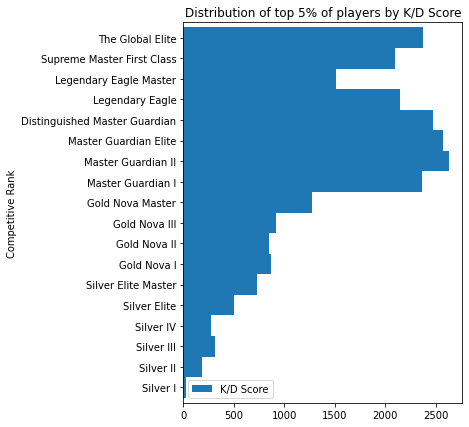

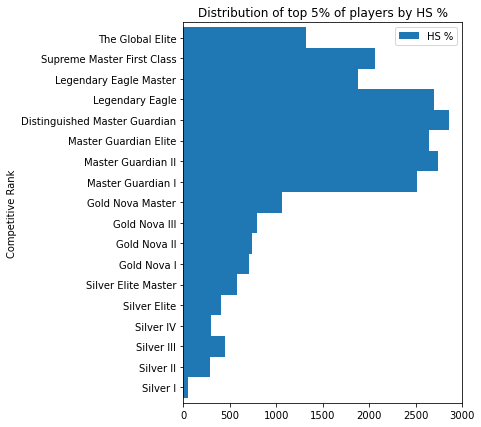

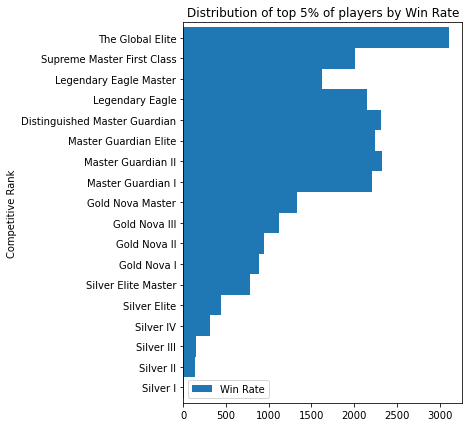

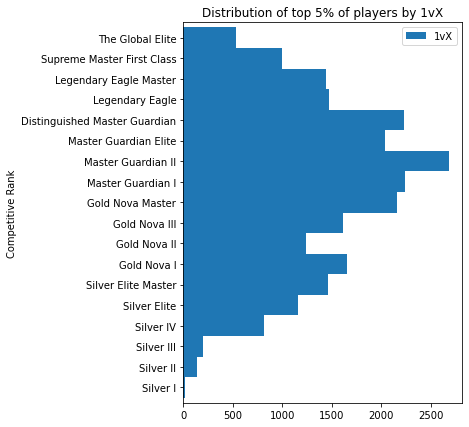

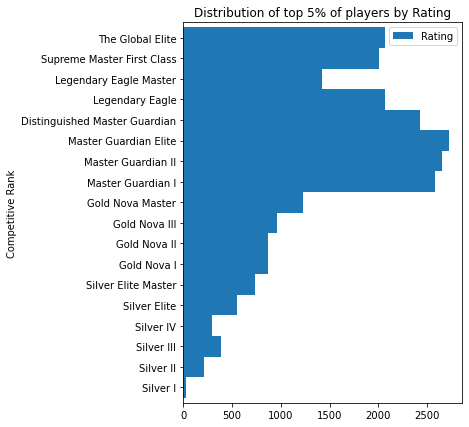

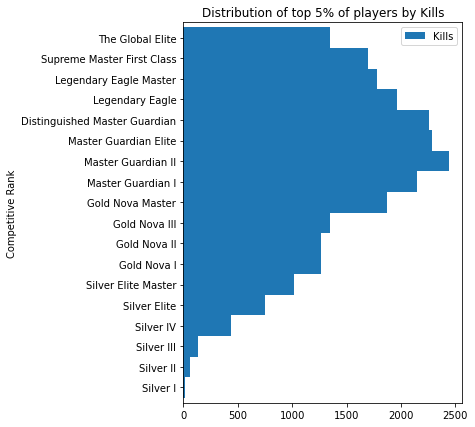

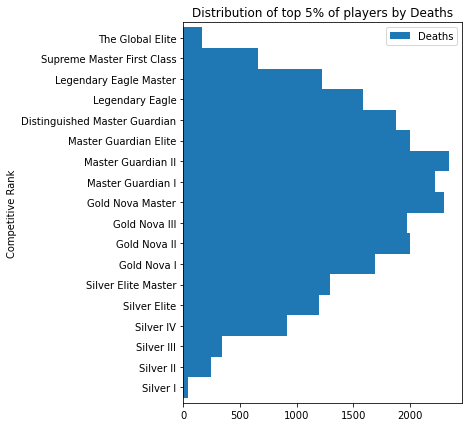

In [7]:
axs = []

for i, cur_df in enumerate(best_per_col):
    axs.append(
        cur_df.plot.barh(title='Distribution of top 5% of players by ' + cols[i],
                     figsize=(5, 7), width=1)
    )

We can see in the distribution graphs that the top players (per category, in terms of z-score) tend to be in the higher competitive ranks. `K/D Score`, `HS %`, `Win Rate`, `Rating`, and `Kills` were more skewed in the direction of the higher ranks, which makes sense since these are the stats that define how "good" a player is. `1vX` and `Deaths` were more normally distributed, but this is also understandable because lower ranks do not need to be as good as the higher ranks in order to win a "1vX" engagement, and player deaths are most commonly caused by round losses, which normally happen across the rank divisons.

Since we know that most top players in terms of player statistics belong to the higher ranks, this leads us to another question:

## How much do player stats predict rankings?
To know this, we will perform a Spearman correlation between the player statistics and their Leaderboards Rank and Competitive Rank—which, in a sense is also an ordinal ranking.

In [16]:
# Get correlation
leaderboard_spearman = df.corr(method='spearman')

# Drop other ordinal rank scale
leaderboard_spearman.drop('Encoded Competitive Rank', inplace=True)

# Visualize
leaderboard_spearman['Leaderboards Rank'].to_frame().style.background_gradient(cmap='RdYlGn')

,Leaderboards Rank
Leaderboards Rank,1.000000
K/D Score,-0.730831
HS %,-0.047860
Win Rate,-0.281595
1vX,-0.332324
Rating,-0.749954
Kills,-0.558217
Deaths,0.232591


The resulting spearman correlation for `Leaderboards Rank` is not very strong throughout the different player statistics. This is understandable because the site gave players a leaderboard rank in accordance to the rank division they were in. Since every rank had, for example a "Top 1" player, which had different player statistics across the different ranks, there is more variation in the data, affecting the correlation. It only resulted at most a **Strong** correlation for `K/D Score` and `Rating`. Despite this, it still makes sense as these are the most impactful metrics of a player's skill.

A better reference for a spearman correlation is the player's Competitive Rank, which itself is an ordinal rank—the highest rank (The Global Elite) being number 1.

In [23]:
# Represent competitive groups by their average
comp_df = df.groupby('Competitive Rank').mean()

# Drop other ordinal rank scale
comp_df.drop(columns='Leaderboards Rank', inplace=True)

# Get correlation and visualize
comp_spearman = comp_df.corr(method = "spearman")
comp_spearman['Encoded Competitive Rank'].to_frame().style.background_gradient(cmap='RdYlGn')

,Encoded Competitive Rank
K/D Score,-0.991744
HS %,-1.000000
Win Rate,-0.977296
1vX,-0.236326
Rating,-0.991744
Kills,-0.587203
Deaths,-0.019608
Encoded Competitive Rank,1.000000


The Spearman correlation for the Competitive Rank showed better results in comparison to the correlation with the Leaderboards rank. This is because we took the average stats of the players in each rank before correlating with their competitive rank. Doing so allowed us to perform a correlation on the "best representation" of every competitive rank group. At best, it resulted in a monotonic correlation for `HS %`, and very strong correlations through other statistics such as `K/D Score`, `Win Rate`, and `Rating`.

Additionally notice that both correlations were negative, however this is reasonable as the player's rank and their other statistics (Kills, win rate, etc.) should be inversely related. A higher ordinal rank player (lower numerical value) would theoretically be scoring more kills and wins than that of a lower ordinal rank player (higher numerical value).

# Conclusion
In summary, we found that the average stats of players through different competitive rank divisions tended to go higher as their competitive rank increased. Additionally, most of the better performing players comprised the higher ranking players as well. Additional tests showed that there was a very strong correlation between a player's competitive rank and their statistics.

We can conclude that with this a player's rank matters; however it is only for predicting their likely rank. There is a very strong correlation between a player's statistics and their rank, however it does not necessarily cause or imply them to be a high ranked player. We can infer that a higher ranked player is likely to have higher statistics, but not the reverse. A player having higher statistics in their group only likely means that they belong in a higher competitive group.